# Fraud Detection on Bank Payments

## Fraud and detecting it

Fraudulent behavior can be seen across many different fields such as e-commerce, healthcare, payment and banking systems. Fraud is a billion-dollar business and it is increasing every year. The PwC global economic crime survey of 2018 [1] found that half (49 percent) of the 7,200 companies they surveyed had experienced fraud of some kind.

Even if fraud seems to be scary for businesses it can be detected using intelligent systems such as rules engines or machine learning. Most people here in Kaggle are familier with machine learning but for rule engines here is a quick information. 
    A rules engine is a software system that executes one or more business rules in a runtime production environment. These rules are generally written by domain experts for transferring the knowledge of the problem to the rules engine and from there to production. Two rules examples for fraud detection would be limiting the number of transactions in a time period (velocity rules),  denying the transactions which come from previously known fraudulent IP's and/or domains.
    
Rules are great for detecting some type of frauds but they can fire a lot of false positives or false negatives in some cases because they have predefined threshold values. For example let's think of a rule for denying a transaction which has an amount that is bigger than 10000 dollars for a specific user. If this user is an experienced fraudster, he/she may be aware of the fact that the system would have a threshold and he/she can just make a transaction just below the threshold value (9999 dollars).

For these type of problems ML comes for help and reduce the risk of frauds and the risk of business to lose money. With the combination of rules and machine learning, detection of the fraud would be more precise and confident.

## Banksim dataset

We detect the fraudulent transactions from the Banksim dataset. This synthetically generated dataset consists of payments from various customers made in different time periods and with different amounts. For
more information on the dataset you can check the [Kaggle page](https://www.kaggle.com/ntnu-testimon/banksim1) for this dataset which also has the link to the original paper. 

Here what we'll do in this kernel:
1. [Exploratory Data Analysis (EDA)](#Explaratory-Data-Analysis)
2. [Data Preprocessing](#Data-Preprocessing)
3. [Oversampling with SMOTE](#Oversampling-with-SMOTE)
4. [K-Neighbours Classifier](#K-Neighbours-Classifier)
5. [Random Forest Classifier](#Random-Forest-Classifier)
6. [XGBoost Classifier](#XGBoost-Classifier)
7. [Conclusion](#Conclusion)

## Explaratory Data Analysis

In this chapter we will perform an EDA on the data and try to gain some insight from it.

In [2]:
pip install imbalanced-learn

     ------------------------------------ 235.6/235.6 kB 847.4 kB/s eta 0:00:00
     -------------------------------------- 302.2/302.2 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Necessary imports

## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

**Data**
As we can see in the first rows below the dataset has 9 feature columns and a target column. 
The feature columms are :
* **Step**: This feature represents the day from the start of simulation. It has 180 steps so simulation ran for virtually 6 months.
* **Customer**: This feature represents the customer id
* **zipCodeOrigin**: The zip code of origin/source.
* **Merchant**: The merchant's id
* **zipMerchant**: The merchant's zip code
* **Age**: Categorized age 
    * 0: <= 18, 
    * 1: 19-25, 
    * 2: 26-35, 
    * 3: 36-45,
    * 4: 46:55,
    * 5: 56:65,
    * 6: > 65
    * U: Unknown
* **Gender**: Gender for customer
     * E : Enterprise,
     * F: Female,
     * M: Male,
     * U: Unknown
* **Category**: Category of the purchase. I won't write all categories here, we'll see them later in the analysis.
* **Amount**: Amount of the purchase
* **Fraud**: Target variable which shows if the transaction fraudulent(1) or benign(0)

In [5]:
# read the data and show first 5 rows
data = pd.read_csv("bs140513_032310.csv")
data.head(5)

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


Let's look at column types and missing values in data.  Oh im sorry there is **no** missing values which means we don't have to perform an imputation.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         594643 non-null  int64  
 1   customer     594643 non-null  object 
 2   age          594643 non-null  object 
 3   gender       594643 non-null  object 
 4   zipcodeOri   594643 non-null  object 
 5   merchant     594643 non-null  object 
 6   zipMerchant  594643 non-null  object 
 7   category     594643 non-null  object 
 8   amount       594643 non-null  float64
 9   fraud        594643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


**Fraud data** will be imbalanced like you see in the plot below and from the count of instances. To balance the dataset one can perform oversample or undersample techniques. Oversampling is increasing the number of the minority class by generating instances from the minority class . Undersampling is reducing the number of instances in the majority class by selecting random points from it to where it is equal with the minority class. Both operations have some risks: Oversample will create copies or similar data points which sometimes would not be helpful for the case of fraud detection because fraudulent transactions may vary. Undersampling means that we lost data points thus information. We will perform an oversampled technique called SMOTE (Synthetic Minority Over-sampling Technique). SMOTE will create new data points from minority class using the neighbour instances so generated samples are not exact copies but they are similar to instances we have.

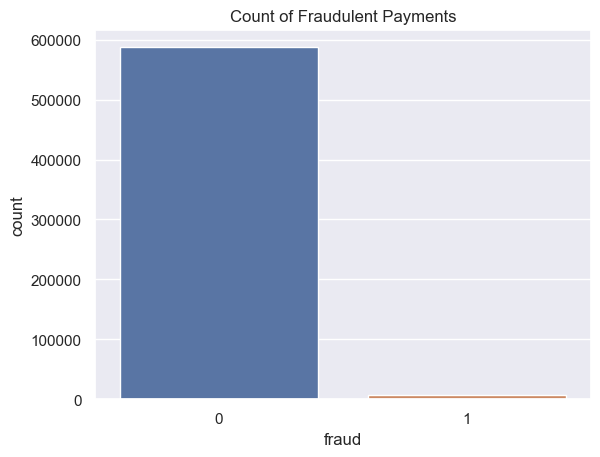

Number of normal examples:  587443
Number of fradulent examples:  7200


In [7]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = data.loc[data.fraud == 1] 
df_non_fraud = data.loc[data.fraud == 0]

sns.countplot(x="fraud",data=data)
plt.title("Count of Fraudulent Payments")
plt.show()
print("Number of normal examples: ",df_non_fraud.fraud.count())
print("Number of fradulent examples: ",df_fraud.fraud.count())
#print(data.fraud.value_counts()) # does the same thing above

We can see the mean amount and fraud percent by category below. Looks like leisure and the travel is the most selected categories for fraudsters. Fraudsters chose the categories which people spend more on average. Let's confirm this hypothesis by checking the fraud and non-fraud amount transacted.

In [8]:
print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())

Mean feature values per category                               amount     fraud
category                                      
'es_barsandrestaurants'    43.461014  0.018829
'es_contents'              44.547571  0.000000
'es_fashion'               65.666642  0.017973
'es_food'                  37.070405  0.000000
'es_health'               135.621367  0.105126
'es_home'                 165.670846  0.152064
'es_hotelservices'        205.614249  0.314220
'es_hyper'                 45.970421  0.045917
'es_leisure'              288.911303  0.949900
'es_otherservices'        135.881524  0.250000
'es_sportsandtoys'        215.715280  0.495252
'es_tech'                 120.947937  0.066667
'es_transportation'        26.958187  0.000000
'es_travel'              2250.409190  0.793956
'es_wellnessandbeauty'     65.511221  0.047594


C:\Users\MD MUFEED\AppData\Local\Temp\ipykernel_4468\1703450169.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  print("Mean feature values per category",data.groupby('category')['amount','fraud'].mean())


Our hypothesis for fraudsters choosing the categories which people spend more is only partly correct, but as we can see in the table below we can say confidently say that a fraudulent transaction will be much more (about four times or more) than average for that category.

In [9]:
# Create two dataframes with fraud and non-fraud data 
pd.concat([df_fraud.groupby('category')['amount'].mean(),df_non_fraud.groupby('category')['amount'].mean(),\
           data.groupby('category')['fraud'].mean()*100],keys=["Fraudulent","Non-Fraudulent","Percent(%)"],axis=1,\
          sort=False).sort_values(by=['Non-Fraudulent'])

,Fraudulent,Non-Fraudulent,Percent(%)
category,,,
'es_transportation',NaN,26.958187,0.000000
'es_food',NaN,37.070405,0.000000
'es_hyper',169.255429,40.037145,4.591669
'es_barsandrestaurants',164.092667,41.145997,1.882944
'es_contents',NaN,44.547571,0.000000
'es_wellnessandbeauty',229.422535,57.320219,4.759380
'es_fashion',247.008190,62.347674,1.797335
'es_leisure',300.286878,73.230400,94.989980
'es_otherservices',316.469605,75.685497,25.000000


Average amount spend it categories are similar; between 0-500 discarding the outliers, except for the travel category which goes very high. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


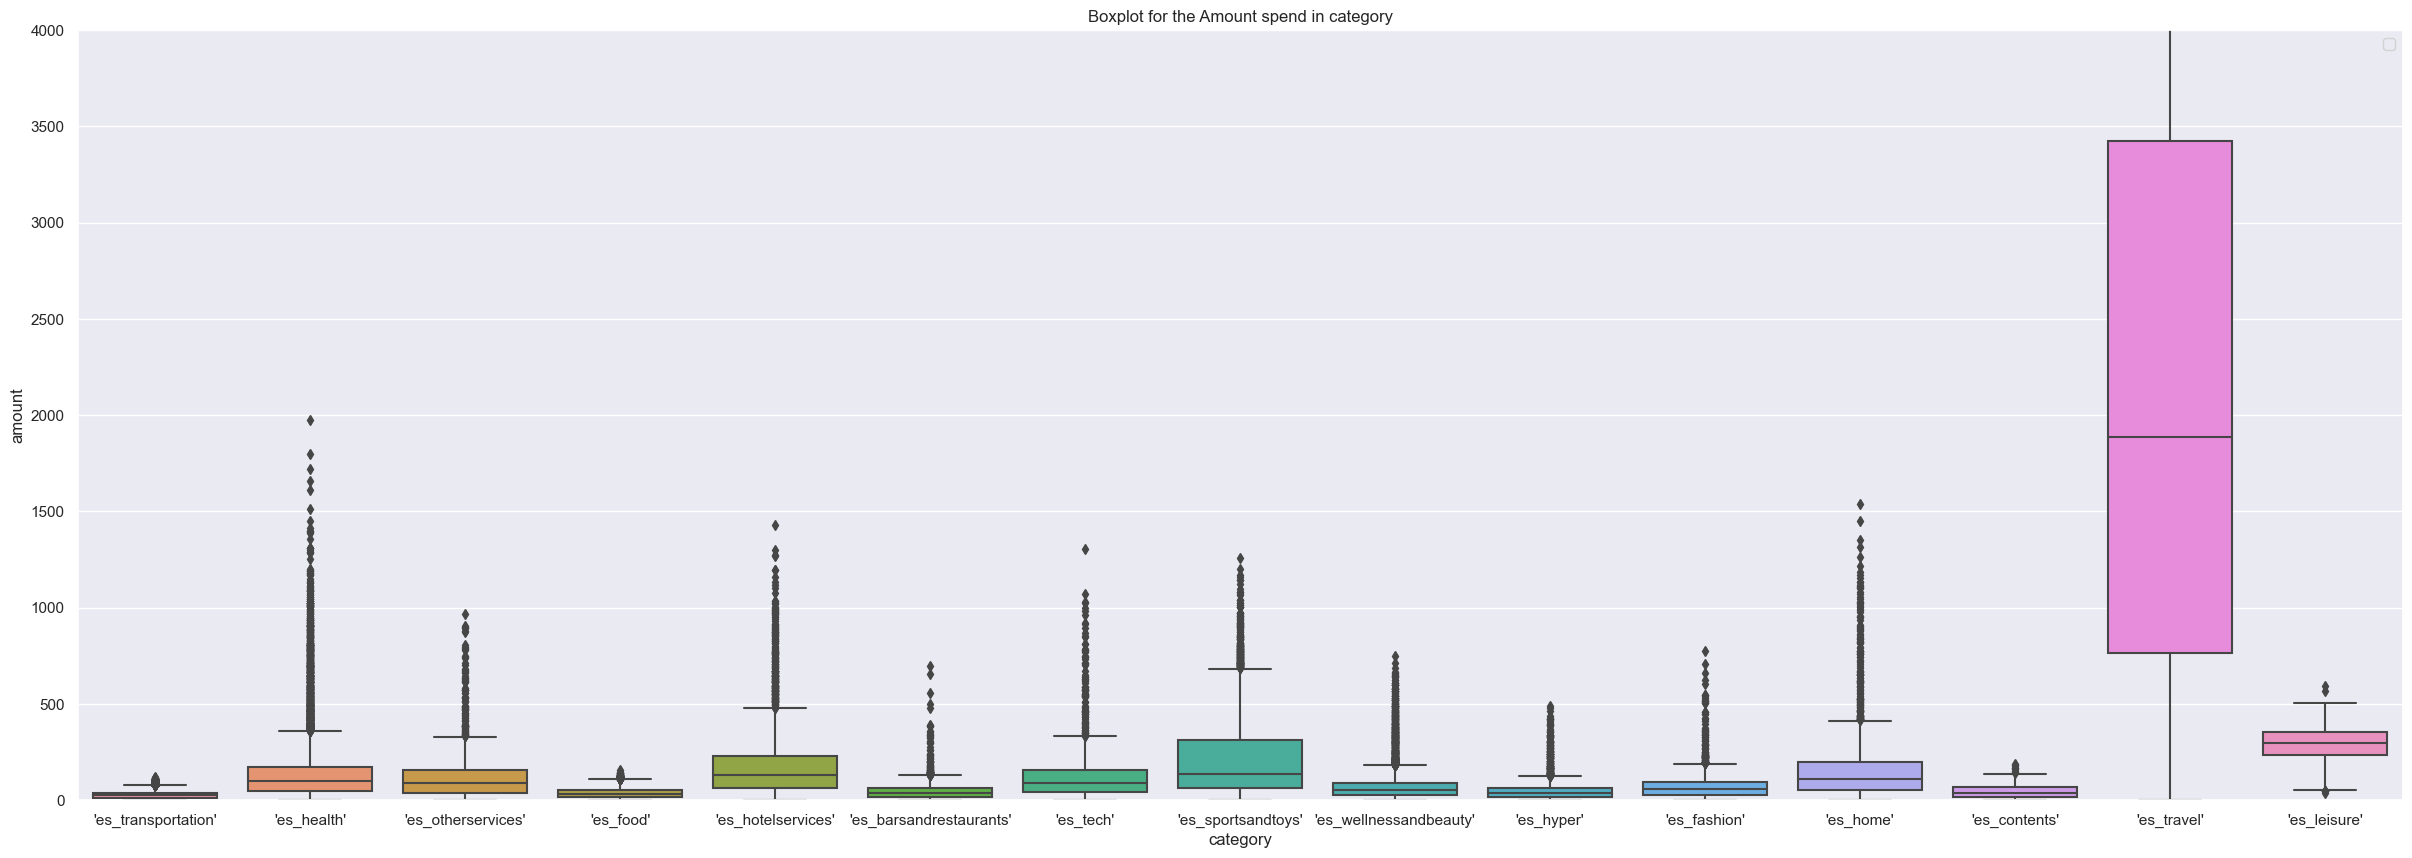

In [10]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(30,10))
sns.boxplot(x=data.category,y=data.amount)
plt.title("Boxplot for the Amount spend in category")
plt.ylim(0,4000)
plt.legend()
plt.show()

Again we can see in the histogram below the fradulent transactions are less in count but more in amount.

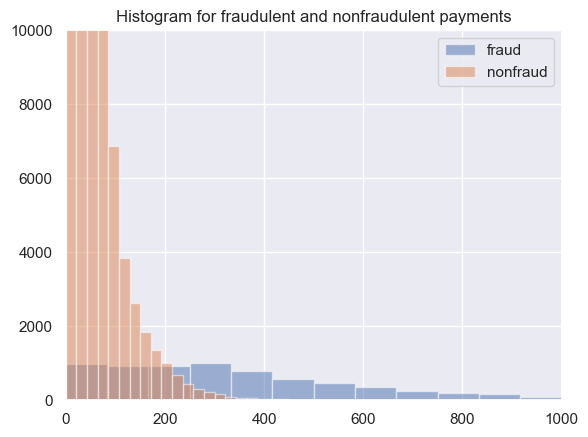

In [11]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud',bins=100)
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud',bins=100)
plt.title("Histogram for fraudulent and nonfraudulent payments")
plt.ylim(0,10000)
plt.xlim(0,1000)
plt.legend()
plt.show()

Looks like fraud occurs more in ages equal and below 18(0th category). Can it be because of fraudsters thinking it would be less consequences if they show their age younger, or maybe they really are young.

In [12]:
print((data.groupby('age')['fraud'].mean()*100).reset_index().rename(columns={'age':'Age','fraud' : 'Fraud Percent'}).sort_values(by='Fraud Percent'))

   Age  Fraud Percent
7  'U'       0.594228
6  '6'       0.974826
5  '5'       1.095112
1  '1'       1.185254
3  '3'       1.192815
2  '2'       1.251401
4  '4'       1.293281
0  '0'       1.957586


## Data Preprocessing

In this part we will preprocess the data and prepare for the training.

There are only one unique zipCode values so we will drop them.

In [13]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
# dropping zipcodeori and zipMerchant since they have only one unique value
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


Checking the data after dropping.

In [14]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

Here we will transform categorical features into numerical values. It is usually better to turn these type of categorical values into dummies because they have no relation in size(i.e. customer1 is not greater than customer2) but since they are too many (over 500k customers and merchants) the features will grow 10^5 in size and it will take forever to train. I've put the code below for turning categorical features into dummies if you want to give it a try.
> data_reduced.loc[:,['customer','merchant','category']].astype('category')
> data_dum = pd.get_dummies(data_reduced.loc[:,['customer','merchant','category','gender']],drop_first=True) # dummies
> print(data_dum.info())

In [15]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


Let's define our independent variable (X) and dependant/target variable y

In [16]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [17]:
y[y==1].count()

7200

## Oversampling with SMOTE

Using SMOTE(Synthetic Minority Oversampling Technique) [2] for balancing the dataset. Resulted counts show that now we have exact number of class instances (1 and 0).

In [22]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res.value_counts())

fraud
0        587443
1        587443
dtype: int64


I will do a train test split for measuring the performance. I haven't done cross validation since we have a lot of instances and i don't want to wait that much for training but it should be better to cross validate most of the times. 

In [23]:
# I won't do cross validation since we have a lot of instances
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

I will define a function for plotting the ROC_AUC curve. It is a good visual way to see the classification performance.

In [24]:
# %% Function for plotting ROC_AUC curve

def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

As i talked about it before fraud datasets will be imbalanced and most of the instances will be non-fraudulent. Imagine that we have the dataset here and we are always predicting non-fraudulent. Our accuracy would be almost 99 % for this dataset and mostly for others as well since fraud percentage is very low. Our accuracy is very high but we are not detecting any frauds so it is a useless classifier. So the base accuracy score should be better at least than predicting always non-fraudulent for performing a detection.

In [25]:
# The base score should be better than predicting always non-fraduelent
print("Base accuracy score we must beat is: ", 
      df_non_fraud.fraud.count()/ np.add(df_non_fraud.fraud.count(),df_fraud.fraud.count()) * 100)

Base accuracy score we must beat is:  98.7891894800746


## **K-Neighbours Classifier**

D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
D:\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


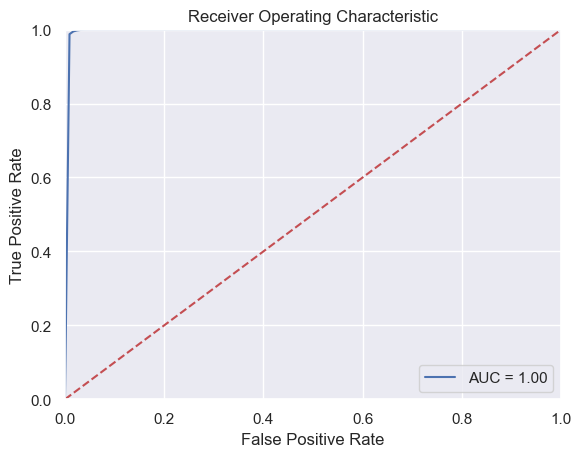

In [26]:
# %% K-ello Neigbors

knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

## **Random Forest Classifier**

C:\Users\MD MUFEED\AppData\Local\Temp\ipykernel_4468\2368093465.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(X_train,y_train)
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   55.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.4s


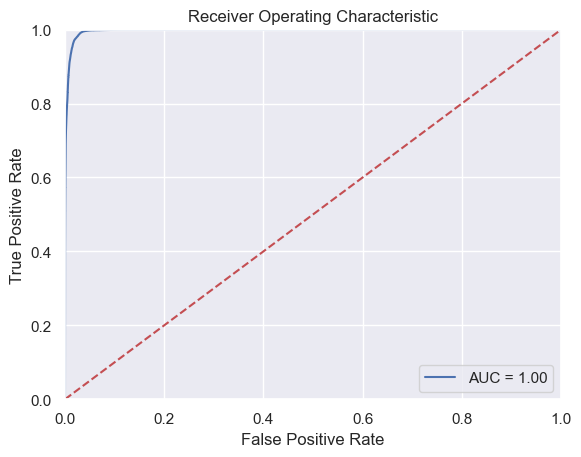

In [28]:
# %% Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

## XGBoost Classifier

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174183   2050]
 [   709 175524]]


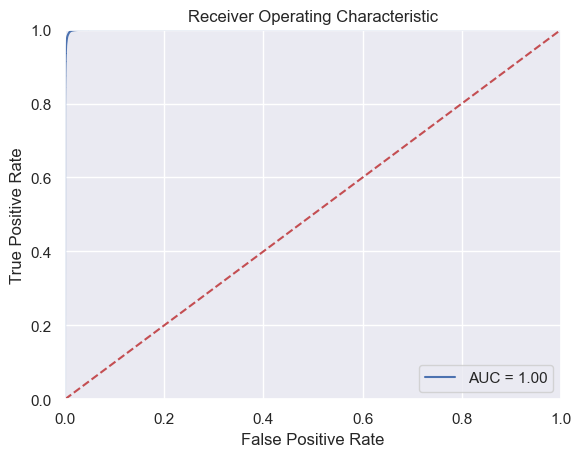

In [31]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:logistic", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=1)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])